In [ ]:
from database import *
import database.models as models

# load full text from db
aps_details_single = models.Review().query.filter(models.Review.status.in_(('needs_crosscheck', 'done'))).filter(models.Review.review_type == 'single_focus').all()

len(aps_details_single)

In [15]:
titles = [i.reviewed_book_title for i in aps_details_single]
authors = [i.reviewed_author_name for i in aps_details_single]
years = [i.year for i in aps_details_single]
publishers = [i.reviewed_book_publisher for i in aps_details_single]
author_viafs = [i.reviewed_author_viaf_match for i in aps_details_single ]
publisher_viafs = [i.reviewed_book_publisher_viaf_match for i in aps_details_single]
known_publishers = list(set([i for i in publishers if i != '' and i is not None]))
len(known_publishers)

245

In [16]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from fuzzysearch import find_near_matches
from collections import Counter
import re
import string

def is_word(word):
    """
    Returns true if word is found in sym_spell dictionary, otherwise returns false.
    """
    try:
        fake = sym_spell._words[word]
        return True
    except:
        return False

def is_surname(surname):
    """
    Returns true if name is found in sym_spell author surname dictionary, otherwise returns false.
    """
    try:
        fake = author_surname_dict._words[surname.lower()]
        return True
    except:
        return False

def fix_hyphenated_words(toks):
    """
    Replaces hyphenated words with single word.
    """
    dash_indices = find_dashes(toks)
    to_be_deleted = []
    for i in dash_indices:
        #if neither are words, e.g. pieces of names or misspellings
        if (is_word(toks[i][:-1])==False or is_word(toks[i+1])==False):
            #replace first item with combined, delete second item
            to_be_deleted.append(i+1)
            toks[i] = (toks[i][:-1] + toks[i+1])
            #if combined is a word
        elif (is_word((toks[i][:-1] + toks[i+1]))):
            to_be_deleted.append(i+1)
            toks[i] = (toks[i][:-1] + toks[i+1])
        elif (is_surname((toks[i][:-1] + toks[i+1]))):
            to_be_deleted.append(i+1)
            toks[i] = (toks[i][:-1] + toks[i+1])
        else:
            pass
    #do this after so u don't heck up the indices
    toks = [w for i, w in enumerate(toks) if i not in to_be_deleted]
    return toks

def find_dashes(toks):
    """
    Returns list of indices for words ending in dashes.
    """
    dash_indices = [i for i, word in enumerate(toks) if (len(word)>1) and (word.endswith('-'))]
    return dash_indices

def remove_function_head(sequence):
    if sequence:
        if sequence[0][0].islower():
            sequence.pop(0)
            return remove_function_head(sequence)
        else:
            return sequence
    else:
        return None
    
def remove_function_tail(sequence):
    if sequence: 
        if sequence[-1].lower() in stopwords.words('english'):
            sequence.pop()
            return remove_function_tail(sequence)
        else:
            return sequence
    else:
        return None

def remove_honorifics(sequence):
    honorifics = """Doctor,Dr,Mr,Mrs,Miss,Msgr,Monsignor,Rev,Reverend,Hon,Honorable,Honourable,Prof,Professor,Madame,Madam,Lady,Lord,Sir,Dame,Master,Mistress,Princess,Prince,Duke,Duchess,Baron,Father,Chancellor,Principal,President,Pres,Warden,Dean,Regent,Rector,Provost,Director"""
    honorific_list = honorifics.lower().split(',')
    if sequence:
        if len(sequence) == 1 and sequence[0].lower() in honorific_list:
            return None
        else:
            return sequence
    else:
        return None
        
def cull_title(text_block, patterns):
    for i in patterns:
        text_block = text_block.replace(i, "")
    culled_title_candidates = [list(),]
    for token in word_tokenize(text_block):
        if token[0].isupper() or token.lower() in stopwords.words('english') or token in string.punctuation:
            if len(culled_title_candidates[-1]) > 0:
                if token not in string.punctuation:
                    culled_title_candidates[-1].append(token)
            else:
                if token[0].isupper():
                    culled_title_candidates[-1].append(token)
        else:
            if len(culled_title_candidates[-1]) > 0:
                culled_title_candidates.append(list())
    # remove any culled_title_candidate if it's just an honorific
    candidates_tidy = []
    for sequence in culled_title_candidates:
        
        if len(sequence) > 0:
            #remove lowercase function word heads and tails recursively
            sequence = remove_function_tail(sequence)
            sequence = remove_function_head(sequence)
            sequence = remove_honorifics(sequence)
            if sequence:
                
                candidates_tidy.append(" ".join(sequence).lower())
    return candidates_tidy

class ReviewObject():
    """
    object class for a book review, including variables for labels, full text, parsed entities, match data, etc.
    tokens_raw (list)
    tokens_tidy (list)
    title_candidates {candidate_string: score, candidate_string: score}
    author_candidates {candidate_string: score, candidate_string: score}
    publisher_candidates {candidate_string: score, candidate_string: score}
    candidate_mappings {"authors": { candidate_string: {match_string: match_score, match_string: match_score}}, "titles": None, "publishers": None}
    
    """
    def __init__(self, title, full_text, **kwargs):
        # instantiate with metdata from db
        self.title = title
        self.full_text = full_text
        self.__dict__.update(kwargs)
        self.make_tokens()
        self.make_tidy()
        self.extract_title_candidates()
        self.extract_author_candidates()
        self.extract_publisher_candidates()
        self.map_candidates_to_entities()
        self.select_top_matches()
        
    def make_tokens(self):
        self.tokens_raw = word_tokenize(self.full_text)

    def make_tidy(self):
        #adding space around certain problem punctuation
        txt = re.sub(',',' , ',self.full_text)
        txt = re.sub(';',' ; ',txt)
        txt = re.sub(':',' : ',txt)
        txt = re.sub('"',' " ',txt)
        txt = re.sub('&',' & ',txt)
        txt = re.sub("'(?!s)"," ' " ,txt)
        # remove extra whitespace
        txt = re.sub(' +',' ',txt)
        # fix hyphenated words
        txt = ' '.join(fix_hyphenated_words(txt.split()))
        #putting space back
        txt = re.sub(' , ',', ',txt)
        txt = re.sub(' ; ','; ',txt)
        txt = re.sub(' : ',': ',txt)
        #and fixing hyphen issues
        txt = re.sub('-(?!\w)',' - ',txt)
        self.text_tidy = re.sub('(?<!\w)-',' - ',txt)
        self.tokens_tidy = word_tokenize(self.text_tidy)
        
        self.text_tidy_lower = self.text_tidy.lower()
        self.tokens_tidy_lower = word_tokenize(self.text_tidy_lower)
        
    
    def extract_title_candidates(self):
        """
        1. Look for capitalized string in review title
        2. Look for before and after cues, get capitalized strings
        3. If no cues, look for capitalized strings
        4. Cull obvious false positives 
        """
        patterns = ["chapter of", "chapters of", "latest", "book called", "volume called", "novel called", "volume of", "edition of", "novel", \
                    "study of", "entitled", "the author of", "with the title", "the manner in which" \
                    "book", "story", "life of"]
        
        title_candidates = []
        if self.record_title:
            title_candidates.extend(re.findall("\".+\"", self.record_title))
            title_candidates.extend(re.findall("\'.+\'", self.record_title))
            
        culled_title_candidates_all = []
        for text_block in title_candidates:
            culled_title_candidates_all.extend(cull_title(text_block, patterns))
                
        if len(culled_title_candidates_all) == 0:
            title_candidates.append(self.record_title)
            culled_title_candidates_all = []
            for text_block in title_candidates:
                culled_title_candidates_all.extend(cull_title(text_block, patterns))

            for i in patterns:
                pattern = "".join([i, ".+?\."])
                title_candidates.extend(re.findall(pattern, self.text_tidy))


            for text_block in title_candidates:
                culled_title_candidates_all.extend(cull_title(text_block, patterns))
        
        self.title_candidates = Counter(culled_title_candidates_all)
    
    def extract_author_candidates(self):
        """
        1. Look for honorifics, try to extrapolate surnames
        2. Look for surnames in review title
        2. Look for before and after cues + surnames in text
        3. If no cues, look for capitalized N-grams ending with surnames
        4. Score each candidate entry based on how it was found
        """
        titles = """Doctor,Dr,Mr,Mrs,Miss,Msgr,Monsignor,Rev,Reverend,Hon,Honorable,Honourable,Prof,Professor,Madame,Madam,Lady,Lord,Sir,Dame,Master,Mistress,Princess,Prince,Duke,Duchess,Baron,Father,Chancellor,Principal,President,Pres,Warden,Dean,Regent,Rector,Provost,Director"""
        titles = titles.split(',')

        full_names = {}

        for e,i in enumerate(self.tokens_tidy):
            maybe_title = "".join([z for z in i if z.isalpha()])
            if maybe_title in titles:

                surname = []
                for p in [e+1, e+2, e+3]:
                    try:
                        if text[p][0].isupper():
                            surname.append(text[p])
                    except:
                        pass
                if len(surname) > 0:
                    surname = " ".join(surname).replace("'s", "")
                    surname_cleaned = []
                    for s in surname:
                        if s not in '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~':
                            surname_cleaned.append(s)
                    surname_cleaned = "".join(surname_cleaned)
                    try:
                        check = full_names[surname]
                    except:
                        full_names[surname] = {}
                    try:
                        full_names[surname]['title'].append(maybe_title)
                    except:
                        full_names[surname]['title'] = [maybe_title,]
                    try:
                        full_names[surname]['surname_cleaned'].append(surname_cleaned)
                    except:
                        full_names[surname]['surname_cleaned'] = [surname_cleaned,]

        for surname in full_names.keys():
            s = surname.split()
            for e, i in enumerate(text):
                if text[e:e+len(s)] == s:
                    forename = "".join([x for x in text[e-1] if x.isalpha()])
                    if forename.istitle() and forename not in titles:
                        try:
                            full_names[surname]['forename'].append(forename)
                        except:
                            full_names[surname]['forename'] = [forename,]
                try:
                    forenames = full_names[surname]['forename']
                except:
                    full_names[surname]['forename'] = []

        for name in full_names.keys():
            for i in full_names[name]['forename']:
                try: 
                    full_names[name]['full_name'].append(i + " " + name)
                except:
                    full_names[name]['full_name'] = [i + " " + name,]
            try:
                full = full_names[surname]['full_name']
            except:
                full_names[name]['full_name'] = []
        
        full_name_candidates = {}

        for n in full_names.keys():
            for f in full_names[n]['full_name']:
                try:
                    full_name_candidates[f] += 1
                except:
                    full_name_candidates[f] = 1
        
        author_surname_candidates = {}
        
        # add title and surnames
        for n,o in full_names.items():
            for i in o['surname_cleaned']:
                try:
                    author_surname_candidates[i] +=1
                except:
                    author_surname_candidates[i] =1
                
                # check if surname in a full name
                name_part = False
                for full in full_name_candidates.keys():
                    if i in full:
                        name_part = True
                if not name_part:
                    try: 
                        full_name_candidates[i] += 1
                    except:
                        full_name_candidates[i] = 1
                        
        self.author_candidates = full_name_candidates
        self.author_surname_candidates = author_surname_candidates
    
    def extract_publisher_candidates(self):
        """
        1. Fuzzy match against known publishers, and count mentions
        2. If no matches, look for pub ends and capitalization, and count each candidate
        """
        pub_ends = ['company','co','incorporated','inc','firm','press','group','publishers','publishing', \
            'publications','pub','books','ltd','limited','society','house','associates', 'book', 'university']
        
        self.publisher_candidates = {}
        
        #this list is defined outside the class
        for p in known_publishers:
            #base fuzziness on length of pubname
            if len(p) < 6:
                fuzz=0
            elif len(p) > 5 and len(p) < 10:
                fuzz=1
            elif len(p) > 9 and len(p) < 15:
                fuzz=2
            else:
                fuzz=3
            
            matches = find_near_matches(p, self.text_tidy, max_l_dist=fuzz)
            
            if len(matches) > 0:
                match_strings = [self.text_tidy[m.start:m.end] for m in matches]
                for i in match_strings:
                    try:
                        self.publisher_candidates[p] += 1
                    except:
                        self.publisher_candidates[p] = 1
                        
        if self.publisher_candidates == {}:
            publisher_candidates = [list(),]
            for token in self.tokens_tidy:
                if token[0].isupper() or token in ['and', '&'] or token in string.punctuation:
                    if len(publisher_candidates[-1]) > 0:
                        if token not in string.punctuation:
                            publisher_candidates[-1].append(token) 
                    else:
                        if token.istitle():
                            publisher_candidates[-1].append(token)
                else:
                    if len(publisher_candidates[-1]) > 0:
                        publisher_candidates.append(list())
    
            matches = []
            for sequence in publisher_candidates:
                for token in sequence:
                    normed_token = token.lower().translate(str.maketrans('', '', string.punctuation))
        
                    if normed_token in pub_ends:
                        matches.append(" ".join(sequence))
                        break
                        
            self.publisher_candidates = Counter(matches)

    def map_candidates_to_entities(self):
        """
        1. Set keys with no values if no candidates 
        2. Map and score publisher matches
        3. Map and score author matches
        4. Map and score title matches
        5. Map and score whole book matches
        
        """
        pass
    
    def select_top_matches(self):
        """
        Return one publisher, one title, and one or more authors thought to be the correct matches 
        """

    def __repr__(self):
        return "Review Object titled '%s' with the following instance variables: %s " % (self.title, "'"+"', '".join(self.__dict__.keys())+"'")
    
        

In [2]:
import sys
sys.path.append('../')

from application.name_obj_classes import PubName, PersonName, remove_punct

from application.review_obj_class import ReviewObj

from application.text_preprocessing import preprocess_text

import os
import pandas as pd
import re
from collections import Counter
import numpy as np
import pickle
from nltk.metrics import edit_distance
%pprint

Pretty printing has been turned OFF


In [34]:
review_objects = []
for i in aps_details_single:
    r = ReviewObject(title=i.reviewed_book_title, full_text=i.full_text, record_title=i.record_title)
    review_objects.append(r)

In [4]:
#titles[0], authors[0], author_viafs[0], years[0], publishers[0], publisher_viafs[0]

In [22]:
# vector = every title word, every author name token, every publisher name token 
# ground truth will be a list of token lists, one for each book
ground_truth_lists = []
for e,i in enumerate(titles):
    this_list = []
    for z in [titles, authors, publishers]:
        tokens = word_tokenize(z[e].lower())
        tokens = [j.replace("&", "and") for j in tokens]
        tokens = [j for j in tokens if j not in string.punctuation]
        this_list.extend(tokens)
    ground_truth_lists.append(this_list)
#title = titles[0], authors[0], author_viafs[0], years[0], publishers[0], publisher_viafs[0]

In [40]:
ground_truth_lists[1]

['the', 'confessions', 'of', 'lord', 'byron', 'lord', 'byron', 'w.', 'a.', 'lewis', 'bettany', 'john', 'murray', 'charles', 'scribner', "'s", 'sons']

In [46]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer

In [110]:
all_scores = []
all_text_merged = []

# loop candidate data
for e,t in enumerate(review_objects):
    # true label is titles[e]
    # get text from various attributes (title, publisher, author) 
    # tokenize
    # remove function words and punctuation? 
    text_merged = [] 
    for z in [t.title_candidates, t.author_candidates, t.publisher_candidates]:
        this_list = []
        #z is a dictionary or Counter
        for k,v in z.items():
            #screen out 'review no title'
            tokens = word_tokenize(k.lower())
            tokens = [j.replace("&", "and") for j in tokens]
            tokens = [j for j in tokens if j not in string.punctuation]
            #for r in range(v):
            this_list.extend(tokens)
        match_indices = []
        for n,t in enumerate(this_list):
            if t == 'review':
                try:
                    if this_list[n+1] == 'no':

                        try:
                            if this_list[n+2] == 'title':
                                match_index = n
                                match_indices.append(n)
                        except:
                            pass
                except:
                    pass
        for m in match_indices:
            this_list[m] = ''
            this_list[m+1] = ''
            this_list[m+2] = ''
        this_list = [j for j in this_list if j !='']
        text_merged.extend(this_list)
    all_text_merged.append(text_merged)
    # the true vector becomes comparison_set[-1]
    comparison_set = [Counter(u) for u in ground_truth_lists] + [Counter(text_merged)]
    
    # compare 
    vectorizer = DictVectorizer()
    X = vectorizer.fit_transform(comparison_set)
    vectors = X.toarray()
    # loop all, get similarity, last one is always 1.0
    scores = []
    for v in vectors:
        score = cosine_similarity([v], [vectors[-1]])
        scores.append(score)
    all_scores.append(scores)

In [111]:
all_text_merged[2]

['carnival', 'd.', 'appleton', 'and', 'company', 'd.', 'appleton', 'and', 'company', 'appleton']

In [112]:
# how often is the right answer the top answer? how often is the correct match in the top 5?
output = []
for e, score_grid in enumerate(all_scores):
    df = pd.DataFrame()
    df['score'] = [i[0][0] for i in score_grid][:-1]
    df['title'] = titles
    match = []
    for i in range(len(titles)):
        if e == i:
            match.append('yes')
        else:
            match.append('no')
    df['match'] = match
    output.append(df.sort_values(by="score", ascending=False).reset_index(drop=False))

In [158]:
top_n = []
accuracy = []

for r in range(1, 562):
    results = []
    for i in output:
        df_n = i.iloc[:r]
        # check if 'yes' is in df_n
        result = len(df_n.loc[df_n['match'] == 'yes']) > 0
        results.append(result)
    acc = len([i for i in results if i])/len(results) 
    top_n.append(r)
    accuracy.append(acc)

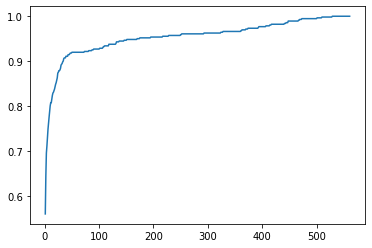

In [159]:
%matplotlib inline
import seaborn as sns
sns.lineplot(x=top_n, y=accuracy)

In [138]:
top_match = []
top_five = []
top_ten = []
top_25 = []
top_50 = []
top_100 = []
top_200 = []
for i in output:
    df_five = i.iloc[:5]
    df_ten = i.iloc[:10]
    df_25 = i.iloc[:25]
    df_50 = i.iloc[:50]
    df_100 = i.iloc[:100]
    df_200 =i.iloc[:200]
    top_match.append(i.iloc[0]['match'] == 'yes')
    top_five.append(len(df_five.loc[df_five['match'] == 'yes']) > 0)
    top_ten.append(len(df_ten.loc[df_ten['match'] == 'yes']) > 0)
    top_25.append(len(df_25.loc[df_25['match'] == 'yes']) > 0)
    top_50.append(len(df_50.loc[df_50['match'] == 'yes']) > 0)
    top_100.append(len(df_100.loc[df_100['match'] == 'yes']) > 0)
    top_200.append(len(df_200.loc[df_200['match'] == 'yes']) > 0)

In [139]:
# 55.97% whole vector
len([i for i in top_match if i])/len(top_match)

0.5597147950089126

In [140]:
# 73% in top five
len([i for i in top_five if i])/len(top_five)

0.7308377896613191

In [141]:
# 80% in top ten
len([i for i in top_ten if i])/len(top_ten)

0.8003565062388592

In [142]:
#87.5% in top 25
len([i for i in top_25 if i])/len(top_25)

0.875222816399287

In [143]:
#91% in top 50
len([i for i in top_50 if i])/len(top_50)

0.9197860962566845

In [145]:
len([i for i in top_200 if i])/len(top_200)

0.9536541889483066

In [126]:
mismatches = []
mismatch_candidate_tokens = []
for e, df in enumerate(output):
    if df.iloc[0]['match'] != 'yes':
        mismatches.append(df)
        mismatch_candidate_tokens.append(all_text_merged[e])
mismatches[2].iloc[0]['title'], mismatches[2].loc[mismatches[2]['match'] == 'yes'].iloc[0]['title'], mismatch_candidate_tokens[2]
mismatches[2].iloc[24]['title']

'Animal Artisans; and Other Studies of Beasts and Birds'

In [ ]:
import requests
from bs4 import BeautifulSoup
#r = requests.get("https://www.worldcat.org/search?q=ti%3Ahuckleberry+finn&fq=yr%3A1865..1925+%3E+%3E+x0%3Abook&qt=advanced&dblist=638")
# page 2 ... "https://www.worldcat.org/search?q=ti%3Ahuckleberry+finn&fq=yr%3A1865..1925+%3E+%3E+x0%3Abook&dblist=638&start=11&qt=page_number_link"
bs = BeautifulSoup(r.text)
bs.find_all("span", {"class":"itemPublisher"})